<div style="display: flex; background-color: RGB(255,114,0); padding: 30px;" >

# <font color='black'> # Analyse de sentiments </font>

</div>


C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from os import getcwd
import matplotlib.image as mpimg
import nltk
from nltk.corpus import stopwords, wordnet
from IPython.core.display import HTML
from collections import Counter
from sklearn.metrics import confusion_matrix


In [2]:
import sys
sys.path.append("C:\\Users\\User\\WORK\\workspace-ia\\PERSO\\")
from ara_commons import ara_nlp_function as ara_nlp
from ara_commons.ara_graph import color_graph_background
from ara_commons.ara_df import get_numeric_columns_names, process_one_hot

In [3]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
file_path

'c:\\Users\\User\\WORK\\workspace-ia\\simplon\\2022-02-NLP-Sentiments-analyses\\'

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Les données
</div>

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). 

Il y a trois fichiers textes à importer et à concaténer pour former un dataset avec deux colonnes:
- Une "texte" comportant le contenu du commentaire
- Une "sentiment" comportant une note de 0 ou 1

In [4]:
print("Chargement des données...")
file_name_amazon_label = "amazon_cells_labelled.txt"
file_name_imdb_labelled = "imdb_labelled.txt"
file_name_yelp_labelled = 'yelp_labelled.txt'

df_origin_amazon_label = pd.read_csv(file_path+"\\data\\"+file_name_amazon_label, sep='\t', header=None)
# Forcer le séparateur, sinon il manque des données, on précise que l'on veut un séparateur suivi d'un 0 ou 1
df_origin_imdb_labelled = pd.read_csv(file_path+"\\data\\"+file_name_imdb_labelled, sep='\t(0|1)', header=None)
df_origin_yelp_labelled= pd.read_csv(file_path+"\\data\\"+file_name_yelp_labelled, sep='\t', header=None)

print("Chargement des données", df_origin_amazon_label.shape, df_origin_imdb_labelled.shape,  df_origin_yelp_labelled.shape, ".......................................... END")

Chargement des données...
Chargement des données (1000, 2) (1000, 3) (1000, 2) .......................................... END


In [5]:
# df_origin_imdb_labelled a une colonne de trop
print(df_origin_imdb_labelled.columns)
df_origin_imdb_labelled.head()

Int64Index([0, 1, 2], dtype='int64')


,0,1,2
0,"A very, very, very slow-moving, aimless movie ...",0,NaN
1,Not sure who was more lost - the flat characte...,0,NaN
2,Attempting artiness with black & white and cle...,0,NaN
3,Very little music or anything to speak of.,0,NaN
4,The best scene in the movie was when Gerardo i...,1,NaN


In [6]:
df_origin_imdb_labelled = df_origin_imdb_labelled.drop(2, axis=1)
df_origin_imdb_labelled.head()

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [7]:
df_origin_amazon_label.head()

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [8]:
df_origin_amazon_label["website"] = "amazon"
df_origin_imdb_labelled["website"] = "imdb"
df_origin_yelp_labelled["website"] = "yelp"

In [9]:
df_origin_full = df_origin_amazon_label.append(df_origin_imdb_labelled)
df_origin_full = df_origin_full.append(df_origin_yelp_labelled)
print(df_origin_full.shape)
df_origin_full.head()

(3000, 3)


,0,1,website
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon


In [10]:
df_origin_full = df_origin_full.rename(columns={0: "sentence", 1: "connotation"})
df_origin_full.columns

Index(['sentence', 'connotation', 'website'], dtype='object')

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Exploration des données: 
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Questions préalables: 
</div>

- Quelle est la taille du dataset ?
- Comment est distribuée la variable sentiment ?

In [11]:
df_origin_full.shape

(3000, 3)

In [12]:
df_origin_full["connotation"].value_counts()

0    1500
1    1500
Name: connotation, dtype: int64

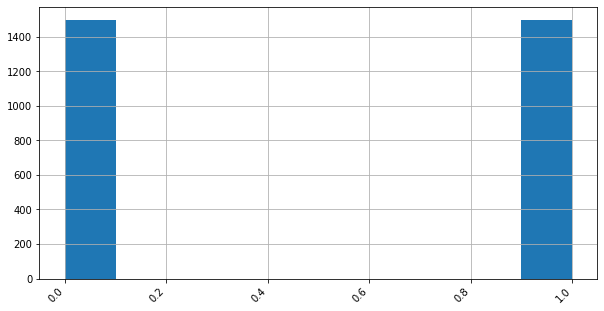

In [13]:
figure, axes = color_graph_background(1, 1)

df_origin_full.connotation.hist()

figure.set_size_inches(10, 5, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

In [14]:
df_origin_full.columns

Index(['sentence', 'connotation', 'website'], dtype='object')

In [15]:
df_origin_full["connotation_label"] = np.nan
df_origin_full.loc[df_origin_full['connotation'] == 0, 'connotation_label'] = "negativ"
df_origin_full.loc[df_origin_full['connotation'] == 1, 'connotation_label'] = "positiv"
df_origin_full

,sentence,connotation,website,connotation_label
0,So there is no way for me to plug it in here i...,0,amazon,negativ
1,"Good case, Excellent value.",1,amazon,positiv
2,Great for the jawbone.,1,amazon,positiv
3,Tied to charger for conversations lasting more...,0,amazon,negativ
4,The mic is great.,1,amazon,positiv
...,...,...,...,...
995,I think food should have flavor and texture an...,0,yelp,negativ
996,Appetite instantly gone.,0,yelp,negativ
997,Overall I was not impressed and would not go b...,0,yelp,negativ
998,"The whole experience was underwhelming, and I ...",0,yelp,negativ


In [16]:
df_group = df_origin_full.groupby(["website", "connotation_label"], as_index=True)['connotation'].count()
df_group

website  connotation_label
amazon   negativ              500
         positiv              500
imdb     negativ              500
         positiv              500
yelp     negativ              500
         positiv              500
Name: connotation, dtype: int64

In [17]:
df_group_ri = df_group.reset_index()
df_group_ri

,website,connotation_label,connotation
0,amazon,negativ,500
1,amazon,positiv,500
2,imdb,negativ,500
3,imdb,positiv,500
4,yelp,negativ,500
5,yelp,positiv,500


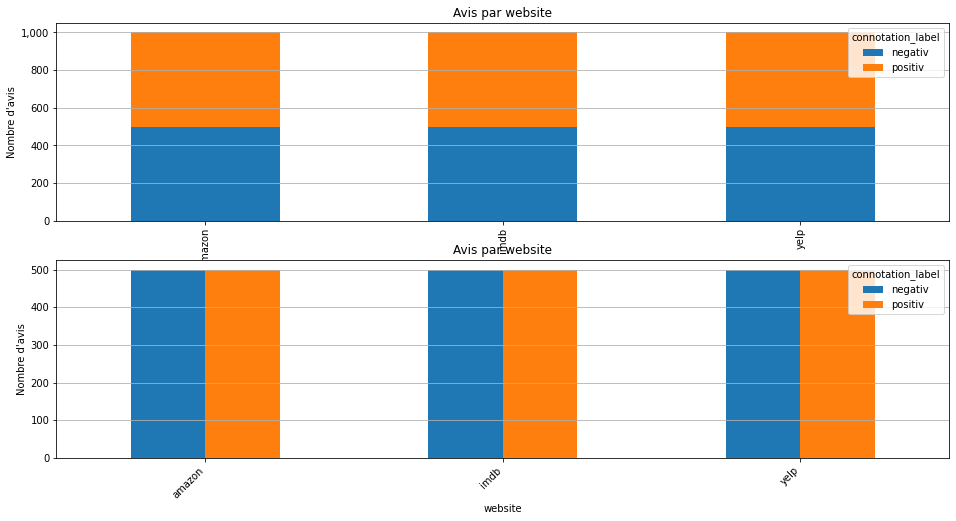

In [18]:
df_group = df_origin_full.groupby(["website", "connotation_label"])['connotation'].count().unstack('connotation_label').fillna(0)
figure, axes = color_graph_background(2, 1)

axe = axes[0]
df_group.plot(kind='bar', stacked=True, title="Avis par website", ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axe.set_ylabel("Nombre d'avis")
axe.grid(axis='y')

axe = axes[1]
df_group.plot(kind='bar', stacked=False, title="Avis par website", ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axe.set_ylabel("Nombre d'avis")
axe.grid(axis='y')

figure.set_size_inches(16, 8, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

In [19]:
df_origin_full = df_origin_full.reset_index()
df_origin_full = df_origin_full.drop("index", axis=1)
df_origin_full.head()

,sentence,connotation,website,connotation_label
0,So there is no way for me to plug it in here i...,0,amazon,negativ
1,"Good case, Excellent value.",1,amazon,positiv
2,Great for the jawbone.,1,amazon,positiv
3,Tied to charger for conversations lasting more...,0,amazon,negativ
4,The mic is great.,1,amazon,positiv


In [20]:
target = 'connotation'

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Pré-processing
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Question 1: Combien y a t'il de mots dans l'ensemble du corpus ? Sont-ils "homogènes" ? 
</div>

### Import du module permettant le traitement de texte: nltk

In [21]:
print(df_origin_full.shape)
df_origin_full.columns

(3000, 4)


Index(['sentence', 'connotation', 'website', 'connotation_label'], dtype='object')

In [22]:
df_nlp = df_origin_full[['website','connotation_label', 'connotation', 'sentence']]
print(df_nlp.shape)
print(df_nlp.columns)
df_nlp

(3000, 4)
Index(['website', 'connotation_label', 'connotation', 'sentence'], dtype='object')


,website,connotation_label,connotation,sentence
0,amazon,negativ,0,So there is no way for me to plug it in here i...
1,amazon,positiv,1,"Good case, Excellent value."
2,amazon,positiv,1,Great for the jawbone.
3,amazon,negativ,0,Tied to charger for conversations lasting more...
4,amazon,positiv,1,The mic is great.
...,...,...,...,...
2995,yelp,negativ,0,I think food should have flavor and texture an...
2996,yelp,negativ,0,Appetite instantly gone.
2997,yelp,negativ,0,Overall I was not impressed and would not go b...
2998,yelp,negativ,0,"The whole experience was underwhelming, and I ..."


In [23]:
from nltk.stem import WordNetLemmatizer
import re
from nltk import word_tokenize

In [24]:
personnal_stop_word = set(stopwords.words('english')) - set(["not","doesn't","don't","hadn't","isn","isn't","mightn't","mustn't","needn't","shouldn't","shouldn","weren't","won't","wouldn","wouldn't","aren't","couldn","couldn't","didn't","didn","doesn","hasn't","haven't","hadn","mustn","hadn","has","no","needn","should've","wasn","wasn't","shan't","t","against",'shan'])

In [25]:
def nlp_pre_process(input, sw=[], verbose=0):
    # ce traitement n'est fait qu'une fois, même si l'on appelle en récurcif la méthode
    stop_words = set(stopwords.words('english')) - set(["not","doesn't","don't","hadn't","isn","isn't","mightn't","mustn't","needn't","shouldn't","shouldn","weren't","won't","wouldn","wouldn't","aren't","couldn","couldn't","didn't","didn","doesn","hasn't","haven't","hadn","mustn","hadn","has","no","needn","should've","wasn","wasn't","shan't","t","against",'shan'])

    review_text = str(input).lower().strip()
    review_text = re.sub('[^a-zA-Z]', " ", review_text)
    review_text = word_tokenize(review_text)
    review_text = [WordNetLemmatizer().lemmatize(word=w, pos='v') for w in review_text if w not in stop_words and len(w) > 2]
    # review_text = ' '.join(review_text)
        
    return review_text

#### Consigne 1: Récupérer le corpus de mots sans la ponctuation ni les stopwords

In [26]:
df_nlp["words"] = df_nlp["sentence"].apply(lambda x: nlp_pre_process(x, sw=personnal_stop_word))
df_nlp["sentence_clean"] = df_nlp["words"].apply(lambda x: " ".join(x))
display(HTML(df_nlp.head().to_html()))

,website,connotation_label,connotation,sentence,words,sentence_clean
0,amazon,negativ,0,So there is no way for me to plug it in here in the US unless I go by a converter.,"[way, plug, unless, converter]",way plug unless converter
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value
2,amazon,positiv,1,Great for the jawbone.,"[great, jawbone]",great jawbone
3,amazon,negativ,0,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,"[tie, charger, conversations, last, minutes, major, problems]",tie charger conversations last minutes major problems
4,amazon,positiv,1,The mic is great.,"[mic, great]",mic great


In [27]:
df_nlp.isna().sum()

website              0
connotation_label    0
connotation          0
sentence             0
words                0
sentence_clean       0
dtype: int64

In [28]:
df_nlp.describe()

,connotation
count,3000.000000
mean,0.500000
std,0.500083
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


<div style="display: flex; background-color: Green; padding: 7px;" >

### Question 2: Combien de mots restent-ils ? 
</div>

In [29]:
df_nlp["nb_old_words"] = df_nlp["sentence"].apply(lambda x: len(x.split()))
df_nlp["nb_words"] = df_nlp["words"].apply(lambda x: len(x))

In [30]:
df_nlp[df_nlp["nb_words"]==0]

,website,connotation_label,connotation,sentence,words,sentence_clean,nb_old_words,nb_words
1125,imdb,positiv,1,10/10,[],,1,0
1788,imdb,positiv,1,10/10,[],,1,0
2140,yelp,negativ,0,Don't do it!!!!,[],,3,0


In [31]:
display(HTML(df_nlp.head(20).to_html()))

,website,connotation_label,connotation,sentence,words,sentence_clean,nb_old_words,nb_words
0,amazon,negativ,0,So there is no way for me to plug it in here in the US unless I go by a converter.,"[way, plug, unless, converter]",way plug unless converter,21,4
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,4
2,amazon,positiv,1,Great for the jawbone.,"[great, jawbone]",great jawbone,4,2
3,amazon,negativ,0,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,"[tie, charger, conversations, last, minutes, major, problems]",tie charger conversations last minutes major problems,11,7
4,amazon,positiv,1,The mic is great.,"[mic, great]",mic great,4,2
5,amazon,negativ,0,I have to jiggle the plug to get it to line up right to get decent volume.,"[jiggle, plug, get, line, right, get, decent, volume]",jiggle plug get line right get decent volume,17,8
6,amazon,negativ,0,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.","[several, dozen, several, hundred, contact, imagine, fun, send, one, one]",several dozen several hundred contact imagine fun send one one,21,10
7,amazon,positiv,1,If you are Razr owner...you must have this!,"[razr, owner, must]",razr owner must,8,3
8,amazon,negativ,0,"Needless to say, I wasted my money.","[needle, say, waste, money]",needle say waste money,7,4
9,amazon,negativ,0,What a waste of money and time!.,"[waste, money, time]",waste money time,7,3


<mark> Attention : les négations ont disparue, ce qui change le sens des phrases</mark>

In [32]:
nb_old_w = df_nlp["nb_old_words"].sum()
nb_w = df_nlp["nb_words"].sum()
print(f"nb_old_words : {nb_old_w}, nb_words : {nb_w}")

nb_old_words : 35495, nb_words : 18347


Graphe général

18347 words


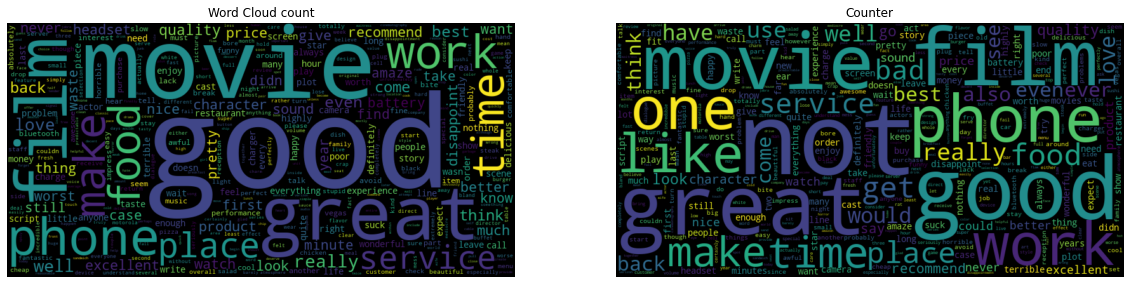

In [33]:
fig, ax = color_graph_background(1,2)

temp = list(df_nlp["words"])
ing_list = []
for igs in temp:
    for ig in igs:
        ing_list.append(ig)
if verbose:
    print(ing_list)
print(len(ing_list), "words")
ara_nlp.draw_word_cloud(ing_list, ax=ax[0])
ax[0].set_title("Word Cloud count")

dict_texte = dict(Counter(ing_list).most_common())
ara_nlp.draw_word_cloud(texte=dict_texte, ax=ax[1])
ax[1].set_title("Counter")

fig.set_size_inches(20, 15, forward=True)
plt.show()


Graphe par site web

In [34]:
websites = df_nlp["website"].unique()
websites

array(['amazon', 'imdb', 'yelp'], dtype=object)

5302 words for  amazon
7475 words for  imdb
5570 words for  yelp


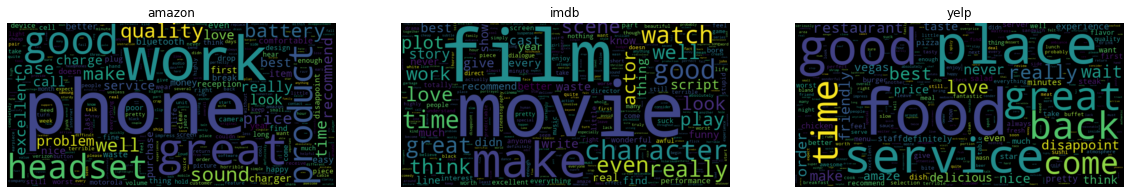

In [35]:
fig, ax = color_graph_background(1,len(websites))

i = 0
for site in websites:
    temp = list(df_nlp.loc[df_nlp["website"]==site,"words"])
    ing_list = []
    for igs in temp:
        for ig in igs:
            ing_list.append(ig)
    if verbose:
        print(ing_list)
    print(len(ing_list), "words for ", site)
    ara_nlp.draw_word_cloud(ing_list, ax=ax[i])
    ax[i].set_title(site)
    i += 1

fig.set_size_inches(20, 15, forward=True)
# plt.xticks(rotation=45, ha="right")
plt.show()

<div style="display: flex; background-color: Blue; padding: 15px;" >

# Exercice 1 : approche td-idf
</div>

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*.

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 2: Utiliser OneHotEncoder ou CountVectorizer pour représenter les données sous forme d'une matrice contenant autant de colonnes que de mots dans le corpus
</div>

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 3: lancer un modèle de classification pour prédire les sentiments de 30% des observations
</div>

*   Séparer échantillon train / test
*   Entrainer un modèle de classification
*   Afficher la matrice de confusion
*   Calculer l'accuracy, la précision et le recall
*   Votre modèle est-il soumis à un overfitting ?

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 4: Utiliser TF-IDF pour représenter les données et relancer un modèle de classification
</div>

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
print(df_nlp.columns)
df_nlp.head()

Index(['website', 'connotation_label', 'connotation', 'sentence', 'words',
       'sentence_clean', 'nb_old_words', 'nb_words'],
      dtype='object')


,website,connotation_label,connotation,sentence,words,sentence_clean,nb_old_words,nb_words
0,amazon,negativ,0,So there is no way for me to plug it in here i...,"[way, plug, unless, converter]",way plug unless converter,21,4
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,4
2,amazon,positiv,1,Great for the jawbone.,"[great, jawbone]",great jawbone,4,2
3,amazon,negativ,0,Tied to charger for conversations lasting more...,"[tie, charger, conversations, last, minutes, m...",tie charger conversations last minutes major p...,11,7
4,amazon,positiv,1,The mic is great.,"[mic, great]",mic great,4,2


<div style="display: flex; background-color: indigo;" >

#### Construction du vecteur et calcul du TF-IDF
</div>

In [39]:
personnal_stop_word

{'a',
 'about',
 'above',
 'after',
 'again',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'd',
 'did',
 'do',
 'does',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hasn',
 'have',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 'more',
 'most',
 'my',
 'myself',
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'she',
 "she's",
 'should',
 'so',
 'some',
 'such',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',


In [40]:
vectorizer_idf_big = TfidfVectorizer(analyzer="word",token_pattern=ara_nlp.get_regex_tokens(), stop_words=personnal_stop_word, ngram_range = (1,3), max_features=400)
X = vectorizer_idf_big.fit_transform(df_nlp['sentence_clean'])
idf_big_df = pd.DataFrame(X.toarray(), index=df_nlp.index, columns=vectorizer_idf_big.get_feature_names_out())
# ajout du site web

# Réorganisation des colonnes pour la lecture
idf_full = pd.merge(df_nlp, idf_big_df, left_index=True, right_index=True)
idf_full = idf_full.drop(["nb_old_words", "connotation_label", "connotation"], axis=1)
# --
idf_full.head()

,website,sentence,words,sentence_clean,nb_words,absolutely,act,actor,actors,actually,...,worse,worst,worth,would,would not,write,wrong,year,years,yet
0,amazon,So there is no way for me to plug it in here i...,"[way, plug, unless, converter]",way plug unless converter,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,amazon,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,amazon,Great for the jawbone.,"[great, jawbone]",great jawbone,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,amazon,Tied to charger for conversations lasting more...,"[tie, charger, conversations, last, minutes, m...",tie charger conversations last minutes major p...,7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,amazon,The mic is great.,"[mic, great]",mic great,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
idf_full.describe()

,nb_words,absolutely,act,actor,actors,actually,ago,almost,also,always,...,worse,worst,worth,would,would not,write,wrong,year,years,yet
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,6.115667,0.004039,0.007068,0.001619,0.003172,0.002745,0.001375,0.002405,0.011007,0.004293,...,0.002559,0.006831,0.004847,0.011528,0.002634,0.003565,0.002147,0.002322,0.003680,0.001652
std,4.166782,0.050589,0.059770,0.030671,0.042689,0.038959,0.025573,0.037943,0.072804,0.050555,...,0.040142,0.062875,0.052016,0.071316,0.036759,0.041524,0.036241,0.034395,0.040575,0.028381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,44.000000,1.000000,1.000000,0.798698,1.000000,0.848308,0.678466,1.000000,1.000000,1.000000,...,0.870643,1.000000,0.864476,1.000000,0.739894,0.727950,0.840586,0.637433,0.682465,0.649117


In [42]:
max_words=200
voca = idf_big_df.T.sum(axis=1).sort_values(axis=0, ascending=False)
voca

not        101.838995
great       90.730839
good        90.604035
film        74.682143
movie       70.811400
              ...    
become       4.471506
verizon      4.399915
ago          4.124159
wife         3.995874
begin        3.893011
Length: 400, dtype: float64

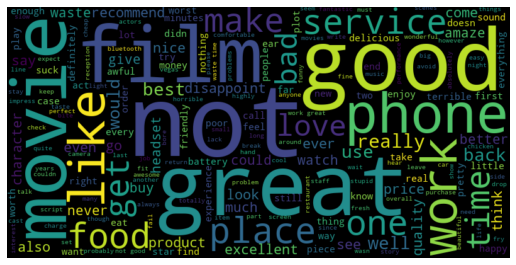

In [43]:
ara_nlp.draw_word_cloud(voca[0:max_words])

<div style="display: flex; background-color: indigo;" >

#### Prédiction
</div>

In [44]:
idf_full.head()

,website,sentence,words,sentence_clean,nb_words,absolutely,act,actor,actors,actually,...,worse,worst,worth,would,would not,write,wrong,year,years,yet
0,amazon,So there is no way for me to plug it in here i...,"[way, plug, unless, converter]",way plug unless converter,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,amazon,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,amazon,Great for the jawbone.,"[great, jawbone]",great jawbone,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,amazon,Tied to charger for conversations lasting more...,"[tie, charger, conversations, last, minutes, m...",tie charger conversations last minutes major p...,7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,amazon,The mic is great.,"[mic, great]",mic great,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# On ajoute le site web qui peut influencer le résultat
idf_full = process_one_hot(idf_full, col="website", verbose=verbose)
idf_full.head()

,website,sentence,words,sentence_clean,nb_words,absolutely,act,actor,actors,actually,...,would,would not,write,wrong,year,years,yet,website_amazon,website_imdb,website_yelp
0,amazon,So there is no way for me to plug it in here i...,"[way, plug, unless, converter]",way plug unless converter,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,amazon,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,amazon,Great for the jawbone.,"[great, jawbone]",great jawbone,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,amazon,Tied to charger for conversations lasting more...,"[tie, charger, conversations, last, minutes, m...",tie charger conversations last minutes major p...,7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,amazon,The mic is great.,"[mic, great]",mic great,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [46]:
numeric_cols = get_numeric_columns_names(idf_full, verbose=verbose)
numeric_cols

['nb_words',
 'absolutely',
 'act',
 'actor',
 'actors',
 'actually',
 'ago',
 'almost',
 'also',
 'always',
 'amaze',
 'amazon',
 'another',
 'anyone',
 'anything',
 'area',
 'around',
 'arrive',
 'art',
 'ask',
 'atmosphere',
 'avoid',
 'away',
 'awesome',
 'awful',
 'back',
 'bad',
 'bar',
 'barely',
 'battery',
 'battery life',
 'beautiful',
 'become',
 'begin',
 'believe',
 'best',
 'better',
 'big',
 'bite',
 'black',
 'bland',
 'bluetooth',
 'bore',
 'break',
 'breakfast',
 'bring',
 'buffet',
 'burger',
 'button',
 'buy',
 'call',
 'camera',
 'car',
 'care',
 'case',
 'cast',
 'cell',
 'cell phone',
 'certainly',
 'character',
 'charge',
 'charger',
 'charm',
 'cheap',
 'check',
 'chicken',
 'cinematography',
 'clear',
 'cold',
 'color',
 'come',
 'come back',
 'comfortable',
 'company',
 'completely',
 'consider',
 'cook',
 'cool',
 'cost',
 'could',
 'could not',
 'couldn',
 'couple',
 'cover',
 'crap',
 'customer',
 'customer service',
 'day',
 'days',
 'deal',
 'definitely'

In [51]:
random_state = 42

In [52]:
# On prend uniquement les colonnes qui nous intéresse (identifiée précédemment)
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(idf_full[numeric_cols], df_nlp[target], test_size=0.2, random_state=random_state)
print(f" Train : {X_train_idf.shape} et {y_train_idf.shape} --- Test : {X_test_idf.shape} et {y_test_idf.shape}")

 Train : (2400, 404) et (2400,) --- Test : (600, 404) et (600,)


In [48]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC

In [63]:
verbose = 0

#Create classifier
model_list = {
    "LogisticR":LogisticRegression(random_state=random_state, verbose=verbose),
    "SVC":svm.SVC(random_state=random_state, verbose=verbose), # SCORE de 0.643333
    "KNN":KNeighborsClassifier(n_neighbors=3), # SCRORE de 0.558333
    "LinearSVC":LinearSVC(random_state=random_state, verbose=verbose),
    "naiveGaussianNB":GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB":BernoulliNB()
}

# Train the model using the training sets
_, scores = ara_nlp.fit_and_test_models(model_list, X_train=X_train_idf, Y_train=y_train_idf, X_test=X_test_idf, Y_test=y_test_idf, verbose=verbose, metrics=1)

score_all_class_df = pd.DataFrame(scores).set_index("Modeli")
score_all_class_df.round(decimals=3)
score_all_class_df

,Class,Model,R2,fit time,fit seconde,metrics time,metrics seconde,predict time,predict seconde,MAE,MSE,RMSE,Mediane AE
Modeli,,,,,,,,,,,,,
LogisticR,,LogisticR,0.790000,00:00:00,0.159350,00:00:00,0.004001,00:00:00,0.003000,0.210000,0.210000,0.458258,0.0
SVC,,SVC,0.593333,00:00:01,1.768640,00:00:00,0.405900,00:00:00,0.404894,0.406667,0.406667,0.637704,0.0
KNN,,KNN,0.611667,00:00:00,0.044505,00:00:00,0.041663,00:00:00,0.040663,0.388333,0.388333,0.623164,0.0
naiveGaussianNB,,naiveGaussianNB,0.740000,00:00:00,0.025499,00:00:00,0.008965,00:00:00,0.006933,0.260000,0.260000,0.509902,0.0
MultinomialNB,,MultinomialNB,0.768333,00:00:00,0.010659,00:00:00,0.003012,00:00:00,0.003012,0.231667,0.231667,0.481318,0.0
ComplementNB,,ComplementNB,0.766667,00:00:00,0.010816,00:00:00,0.003067,00:00:00,0.003067,0.233333,0.233333,0.483046,0.0
BernoulliNB,,BernoulliNB,0.783333,00:00:00,0.024598,00:00:00,0.004000,00:00:00,0.004000,0.216667,0.216667,0.465475,0.0


<div style="display: flex; background-color: indigo;" >

#### GRID Search
</div>

In [64]:
from sklearn.model_selection import GridSearchCV

In [65]:
grid_params_LR = { 'solver' : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                    'penalty' : [None, 'l2', 'l1', 'elasticnet'],
                    'fit_intercept' : [True, False]}
grid_params_LR = { 'solver' : ["liblinear"],
                   'penalty' : ['l2'],
                   'fit_intercept' : [True, False]}

In [66]:
grid_params_GaussianNB = { 'var_smoothing' : np.arange(0.1, 1, 0.1)
                         }

In [67]:
grid_params_MultinomialNB = { 'alpha' : [0,1],
                              'fit_prior' : [True,False]
                            }

In [68]:
grid_params_ComplementNB = { 'alpha' : [0,1],
                              'fit_prior' : [True,False],
                              'norm' : [True,False]
                            }

In [69]:
grid_params_BernoulliNB = { 'alpha' : [0,1],
                            'binarize' : [0.0, 0.5,1],
                            'fit_prior' : [True,False]
                            }

In [70]:
cross_validation = 3
grid_model_list = {
    "Grid_LogisticR":GridSearchCV(estimator=LogisticRegression(random_state=random_state, verbose=verbose), param_grid=grid_params_LR, cv=cross_validation, verbose=verbose),
    "Grid_naiveGaussianNB":GridSearchCV(estimator=GaussianNB(), param_grid=grid_params_GaussianNB, cv=cross_validation, verbose=verbose),
    "Grid_MultinomialNB": GridSearchCV(estimator=MultinomialNB(), param_grid=grid_params_MultinomialNB, cv=cross_validation, verbose=verbose),
    "Grid_ComplementNB":GridSearchCV(estimator=ComplementNB(), param_grid=grid_params_ComplementNB, cv=cross_validation, verbose=verbose),
    "Grid_BernoulliNB":GridSearchCV(estimator=BernoulliNB(), param_grid=grid_params_BernoulliNB, cv=cross_validation, verbose=verbose),
}


In [71]:
# Train the model using the training sets
_, gridscores = ara_nlp.fit_and_test_models(grid_model_list, X_train=X_train_idf, Y_train=y_train_idf, X_test=X_test_idf, Y_test=y_test_idf, scores=scores, verbose=verbose, metrics=1)

score_grid_df = pd.DataFrame(gridscores).set_index("Modeli")
score_grid_df.round(decimals=3)
score_grid_df

,Class,Model,R2,fit time,fit seconde,metrics time,metrics seconde,predict time,predict seconde,MAE,MSE,RMSE,Mediane AE
Modeli,,,,,,,,,,,,,
LogisticR,,LogisticR,0.790000,00:00:00,0.159350,00:00:00,0.004001,00:00:00,0.003000,0.210000,0.210000,0.458258,0.0
SVC,,SVC,0.593333,00:00:01,1.768640,00:00:00,0.405900,00:00:00,0.404894,0.406667,0.406667,0.637704,0.0
KNN,,KNN,0.611667,00:00:00,0.044505,00:00:00,0.041663,00:00:00,0.040663,0.388333,0.388333,0.623164,0.0
naiveGaussianNB,,naiveGaussianNB,0.740000,00:00:00,0.025499,00:00:00,0.008965,00:00:00,0.006933,0.260000,0.260000,0.509902,0.0
MultinomialNB,,MultinomialNB,0.768333,00:00:00,0.010659,00:00:00,0.003012,00:00:00,0.003012,0.231667,0.231667,0.481318,0.0
ComplementNB,,ComplementNB,0.766667,00:00:00,0.010816,00:00:00,0.003067,00:00:00,0.003067,0.233333,0.233333,0.483046,0.0
BernoulliNB,,BernoulliNB,0.783333,00:00:00,0.024598,00:00:00,0.004000,00:00:00,0.004000,0.216667,0.216667,0.465475,0.0
Grid_LogisticR,,Grid_LogisticR,0.790000,00:00:00,0.161020,00:00:00,0.004997,00:00:00,0.004000,0.210000,0.210000,0.458258,0.0
Grid_naiveGaussianNB,,Grid_naiveGaussianNB,0.526667,00:00:00,0.720527,00:00:00,0.007082,00:00:00,0.007082,0.473333,0.473333,0.687992,0.0


<div style="display: flex; background-color: indigo;" >

#### Version Vincent
</div>

In [86]:
from nltk.stem import WordNetLemmatizer
import re
from nltk import word_tokenize

def clean_Review_vincent(review_text):
    stop_words = stopwords.words('english')
    review_text = str(review_text).lower().strip()
    review_text = re.sub('[^a-zA-Z]', " ", review_text)
    review_text = word_tokenize(review_text)
    review_text = [word for word in review_text if word not in stop_words]
    review_text = [WordNetLemmatizer().lemmatize(word=w, pos='v') for w in review_text]
    review_text = [w for w in review_text if len(w) > 2]
    review_text = ' '.join(review_text)
    return review_text

In [87]:
df_vincent = df_origin_full[['website','connotation_label', 'connotation', 'sentence']]

In [88]:
df_vincent['Clean_Sentence'] = df_vincent['sentence'].apply(clean_Review_vincent)

In [92]:
X_vincent = df_vincent['Clean_Sentence']
y_vincent = df_vincent['connotation']
X_train_vincent, X_test_vincent, y_train_vincent, y_test_vincent = train_test_split(X_vincent, y_vincent, test_size=0.3, random_state=random_state)

In [93]:
vectorizer = TfidfVectorizer()

train_tfidf = vectorizer.fit_transform(X_train_vincent)
test_tfidf = vectorizer.transform(X_test_vincent)

print('Train : ' , train_tfidf.shape)
print('Test :' , test_tfidf.shape)

Train :  (2100, 3361)
Test : (900, 3361)


In [99]:
#Create classifier
model_list_vincent = {
    "LogisticR":LogisticRegression(random_state=random_state, verbose=verbose),
    "SVC":svm.SVC(random_state=random_state, verbose=verbose), # SCORE de 0.643333
    "KNN":KNeighborsClassifier(n_neighbors=3), # SCRORE de 0.558333
    "LinearSVC":LinearSVC(random_state=random_state, verbose=verbose),
    "naiveGaussianNB":GaussianNB(),
    # "CategoricalNB":CategoricalNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB":BernoulliNB()
}

# Train the model using the training sets
modeldic_vincent, scores_vincent = ara_nlp.fit_and_test_models(model_list_vincent, X_train=train_tfidf.todense(), Y_train=y_train_vincent, X_test=test_tfidf.todense(), Y_test=y_test_vincent, verbose=verbose, metrics=2)

score_df_vincent = pd.DataFrame(scores_vincent).set_index("Modeli")
score_df_vincent.round(decimals=3)
score_df_vincent

,Class,Model,R2,fit time,fit seconde,metrics time,metrics seconde,predict time,predict seconde,MAE,...,Brier loss,Log loss,F1 micro,F1 macro,F1 weighted,Recall micro,Recall macro,Recall weighted,Roc auc ovo,Roc auc ovr
Modeli,,,,,,,,,,,,,,,,,,,,,
LogisticR,,LogisticR,0.801111,00:00:00,0.199189,00:00:00,0.020140,00:00:00,0.005634,0.198889,...,0.155850,0.486581,0.801111,0.801091,0.801087,0.801111,0.801137,0.801111,0.801137,0.801137
SVC,,SVC,0.793333,00:00:11,11.125531,00:00:04,4.008838,00:00:04,4.003839,0.206667,...,NaN,NaN,0.793333,0.793333,0.793333,0.793333,0.793337,0.793333,0.793337,0.793337
KNN,,KNN,0.618889,00:00:00,0.133896,00:00:00,0.248705,00:00:00,0.126076,0.381111,...,0.228272,0.947721,0.618889,0.585053,0.585317,0.618889,0.618257,0.618889,0.618257,0.618257
naiveGaussianNB,,naiveGaussianNB,0.656667,00:00:00,0.145190,00:00:00,0.117741,00:00:00,0.054005,0.343333,...,0.343333,11.831077,0.656667,0.649001,0.648886,0.656667,0.656998,0.656667,0.656998,0.656998
MultinomialNB,,MultinomialNB,0.812222,00:00:00,0.035363,00:00:00,0.017005,00:00:00,0.005022,0.187778,...,0.151403,0.475888,0.812222,0.812120,0.812130,0.812222,0.812174,0.812222,0.812174,0.812174
ComplementNB,,ComplementNB,0.811111,00:00:00,0.024999,00:00:00,0.015000,00:00:00,0.004004,0.188889,...,0.151411,0.475904,0.811111,0.810998,0.811008,0.811111,0.811061,0.811111,0.811061,0.811061
BernoulliNB,,BernoulliNB,0.808889,00:00:00,0.075510,00:00:00,0.046554,00:00:00,0.019567,0.191111,...,0.134693,0.425390,0.808889,0.808812,0.808804,0.808889,0.808937,0.808889,0.808937,0.808937


<div style="display: flex; background-color: indigo;" >

#### Prédiction NLTK
</div>

In [57]:
from nltk.classify import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(labeled_featuresets=(X_train_idf, y_train_idf))
classifier.show_most_informative_features(n=25)

ValueError: too many values to unpack (expected 2)

<div style="display: flex; background-color: Blue; padding: 15px;" >

# Exercice 2 : word2vec
</div>

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity).

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 5: Utiliser Gensim pour représenter les données et relancer un modèle de classification
</div>

Modélisation avec Gensim sur un modèle pré-entrainé

<div style="display: flex; background-color: indigo;" >

#### Prédiction W2C
</div>

In [ ]:
#Create classifier
model_list_w2v_gensim = {
    "LogisticR":LogisticRegression(random_state=random_state, verbose=verbose),
    "SVC":svm.SVC(random_state=random_state, verbose=verbose),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB":BernoulliNB()
}

old_score = score_grid_df
if old_score is None:
    old_score = scores

# Train the model using the training sets
_, scores_w2vg = ara_nlp.fit_and_test_models(model_list_w2v_gensim, X_train=X_train_idf, Y_train=y_train_idf, X_test=X_test_idf, Y_test=y_test_idf, scores=old_score, verbose=verbose, metrics=1)

score_w2vg_df = pd.DataFrame(scores_w2vg).set_index("Modeli")
score_w2vg_df.round(decimals=3)
score_w2vg_df

In [98]:
import gensim.downloader as api
wv_model = api.load('word2vec-google-news-300')

In [91]:
for index, word in enumerate(wv_model.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(wv_model.index_to_key)} is {word}")

word #0/3000000 is </s>
word #1/3000000 is in
word #2/3000000 is for
word #3/3000000 is that
word #4/3000000 is is
word #5/3000000 is on
word #6/3000000 is ##
word #7/3000000 is The
word #8/3000000 is with
word #9/3000000 is said


In [93]:
vec_king = wv_model['king']
vec_king

array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

In [94]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv_model.similarity(w1, w2)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06


In [95]:
try:
    vec_cameroon = wv_model['cameroon']
except KeyError:
    print("The word 'cameroon' does not appear in this model")

The word 'cameroon' does not appear in this model


In [96]:
print(wv_model.most_similar(positive=['car', 'minivan'], topn=5))

[('SUV', 0.8532192707061768), ('vehicle', 0.8175783753395081), ('pickup_truck', 0.7763688564300537), ('Jeep', 0.7567334175109863), ('Ford_Explorer', 0.7565720081329346)]


In [97]:
print(wv_model.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


In [99]:
from gensim.models import Word2Vec

In [101]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [100]:
model = wv_model
more_sentences = [
    ['Advanced', 'users', 'can', 'load', 'a', 'model',
     'and', 'continue', 'training', 'it', 'with', 'more', 'sentences'],
]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.epochs)


AttributeError: 'KeyedVectors' object has no attribute 'build_vocab'

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 5: Utiliser Word2vec pour représenter les données et relancer un modèle de classification
</div>

In [75]:
df_nlp.columns

Index(['website', 'connotation_label', 'connotation', 'sentence', 'words',
       'sentence_clean', 'nb_old_words', 'nb_words'],
      dtype='object')

In [74]:
X

<3000x400 sparse matrix of type '<class 'numpy.float64'>'
	with 10815 stored elements in Compressed Sparse Row format>

In [78]:
from gensim.utils import tokenize
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in df_nlp['sentence']]
print(sentance[0])

['so', 'there', 'is', 'no', 'way', 'for', 'me', 'to', 'plug', 'it', 'in', 'here', 'in', 'the', 'us', 'unless', 'i', 'go', 'by', 'a', 'converter']


In [ ]:
# (sentences=None, corpus_file=None, vector_size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, epochs=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), comment=None, max_final_vocab=None, shrink_windows=True)

In [82]:
from gensim.models import word2vec
model = word2vec.Word2Vec(sentance, window=3,min_count=2, workers=1)
model.corpus_count

3000

In [85]:
vocab = model.wv.key_to_index
list(vocab)[:5]


['the', 'and', 'i', 'a', 'it']

In [88]:
try:
    print(model.wv['after'].shape)
    print(model.wv['after'][:10])
except KeyError as e:
    print(e)

(100,)
[-0.10780307  0.11510558  0.11682003  0.11987133  0.16043372 -0.6079995
  0.29520503  0.6095091  -0.46553198 -0.2631851 ]


In [87]:
try:
    model.wv['rrrrrrrr']
except KeyError as e:
    print(e)

"Key 'rrrrrrrr' not present"


In [101]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [104]:
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)

In [103]:
model.train([["hello", "world"]], total_examples=1, epochs=1)

(0, 2)

In [105]:
model.train(df_vincent)

NameError: name 'df_vincent' is not defined

In [ ]:
model.train(df_vincent, total_examples=1, epochs=1)

<div style="display: flex; background-color: Blue; padding: 15px;" >

# Exercice 3 : Comparer les deux approches
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 6: Faire un graphique montrant les courbes ROC associées au deux modèles
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 7: Faire un graphique montrant les courbes Precision-Recall associées aux deux modèles
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# BONUS: reprendre l'étape de One_hot_encoding et ajouter une étape de réduction de dimension (type ACP)
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# ANNEXE
</div>

In [ ]:
just to fail

<div style="display: flex; background-color: Green; padding: 7px;" >

### Extracting Concordance and Collocations
</div>

In [71]:
df_nlp.columns

Index(['website', 'connotation_label', 'connotation', 'sentence', 'words',
       'nb_old_words', 'nb_words', 'state_union'],
      dtype='object')

In [ ]:
text_by_website = {}
voca_by_website = {}

words_clean_by_website = {}
voca_clean_by_website = {}

for site in websites:
    text_by_website[site] = " ".join(df_nlp.loc[df_nlp["website"]==site,"sentence"])
    words_clean_by_website[site] = nlp_pre_process(text_by_website[site], string_expected=False, sw=personnal_stop_word, sw_language="english")
    print(f"{site:10} : {len(text_by_website[site])} len, soit : {len(text_by_website[site].split())} words")
    txt = nltk.Text(ara_nlp.ara_tokenize(text_by_website[site]))
    print(txt.concordance("good", lines=5))
    print("                     ------------------------")
    voca_by_website[site] = txt.vocab()
    print(voca_by_website[site].most_common())
    print("                     ------------------------")
    txt2 = nltk.Text(words_clean_by_website[site])
    voca_clean_by_website[site] = txt2.vocab()
    print(voca_clean_by_website[site].most_common())
    print("--------------------------------------------------------------------")

amazon     : 56225 len, soit : 10246 words
Displaying 5 of 77 matches:
in the us unless i go by a converter good case excellent value great for the j
 garbled sound from the headset very good quality though the design is very od
 everyone do not be fooled so far so good works great it clicks into place in 
h and doesn t turn on like it should good protection and does not make phone t
yday and it holds up very well not a good bargain well packaged arrived on tim
None
                     ------------------------
[('the', 519), ('i', 379), ('it', 311), ('and', 311), ('is', 243), ('a', 219), ('this', 208), ('to', 197), ('phone', 168), ('my', 145), ('for', 121), ('of', 120), ('not', 117), ('with', 112), ('very', 104), ('great', 99), ('was', 90), ('on', 90), ('in', 88), ('that', 82), ('t', 80), ('good', 77), ('have', 73), ('you', 71), ('product', 55), ('quality', 49), ('headset', 48), ('had', 48), ('works', 47), ('battery', 46), ('but', 46), ('as', 45), ('s', 45), ('sound', 43), ('so', 42),

In [ ]:
df_nlp["state_union"] = df_nlp["sentence"].apply(lambda x: nltk.Text( ara_nlp.ara_tokenize(x)))
display(HTML(df_nlp.head(20).to_html()))

,website,connotation_label,connotation,sentence,words,nb_old_words,nb_words,state_union
0,amazon,negativ,0,So there is no way for me to plug it in here in the US unless I go by a converter.,"[way, plug, u, unless, go, converter]",21,6,"(so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, converter)"
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",4,4,"(good, case, excellent, value)"
2,amazon,positiv,1,Great for the jawbone.,"[great, jawbone]",4,2,"(great, for, the, jawbone)"
3,amazon,negativ,0,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,"[tie, charger, conversation, last, minute, major, problem]",11,7,"(tied, to, charger, for, conversations, lasting, more, than, 45, minutes, major, problems)"
4,amazon,positiv,1,The mic is great.,"[mic, great]",4,2,"(the, mic, is, great)"
5,amazon,negativ,0,I have to jiggle the plug to get it to line up right to get decent volume.,"[jiggle, plug, get, line, right, get, decent, volume]",17,8,"(i, have, to, jiggle, the, plug, to, get, it, to, line, up, right, to, get, decent, volume)"
6,amazon,negativ,0,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.","[several, dozen, several, hundred, contact, imagine, fun, send, one, one]",21,10,"(if, you, have, several, dozen, or, several, hundred, contacts, then, imagine, the, fun, of, sending, each, of, them, one, by, one)"
7,amazon,positiv,1,If you are Razr owner...you must have this!,"[razr, owner, must]",8,3,"(if, you, are, razr, owner, you, must, have, this)"
8,amazon,negativ,0,"Needless to say, I wasted my money.","[needle, say, waste, money]",7,4,"(needless, to, say, i, wasted, my, money)"
9,amazon,negativ,0,What a waste of money and time!.,"[waste, money, time]",7,3,"(what, a, waste, of, money, and, time)"


In [ ]:
df_nlp.loc[0, "state_union"].concordance("plug", lines=5)

Displaying 1 of 1 matches:
so there is no way for me to plug it in here in the us unless i go by 


In [ ]:
df_nlp.loc[0, "state_union"].concordance("good", lines=5)

no matches
